## **Convolutional Neural Networks for Classification Tasks**

**Purpose of the work**: To use convolutional neural networks (CNNs) for classification tasks. To investigate the impact of different parameters on the result and to use the learned tools.


1. [Download the dataset](https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification/data)
2. Perform preliminary analysis of the dataset: number of images per class, number of classes, image sizes, etc.
3. Use augmentation. Answer whether augmentation is critically important for your task.
4. Build three simple Sequential models. Choose and set training parameters. Let one be significantly larger than the others. For at least one model, do not use regularization or Batch Normalization.
5. Check whether your models are overfitting. Add 2 types of regularization if necessary.
6. Track gradient values for the models from item 4. If issues are present, apply solutions (e.g., data normalization, Batch Normalization or Layer Normalization, Gradient Clipping). Justify the applied solutions.
7. Apply any pre-trained model to your dataset (ResNet, VGG16, MobileNet, etc.). Output TOP-1, TOP-5, TOP-10 errors. Analyze the results.
8. Apply transfer learning. Compare with the result from item 7 and the best model from previous items. Summarize results in a table.
9. Build Class Activation Maps and Saliency Maps. Explain the difference between them and what conclusions you can draw.
10. Conduct an experiment with Teacher-Student models. Use the largest and smallest models from item 4, but take into account the qualitative changes made in items 5 and 6. Summarize results in a table. Analyze the results and draw conclusions.
11. Make overall conclusions about the work and prepare a report.







## **Procedure of the work**

**Import of the necessary libraries**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from torchvision import transforms
from PIL import Image
from collections import defaultdict
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

### **1-2. Loading the dataset and preliminary analysis**

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Path to the main folder
folder_path = '/content/drive/MyDrive/ColabNotebooks/Plants_2'

# Function to count images in a folder, including subfolders
def count_images_in_folder(path):
    image_extensions = ('.jpg')
    total_images = 0
    for root, dirs, files in os.walk(path):
        total_images += len([f for f in files if f.lower().endswith(image_extensions)])
    return total_images

# Recursive function to display the folder tree with the total number of images
def print_folder_tree(path, level=0):
    indent = ' ' * 8 * level
    total_images = count_images_in_folder(path)
    print(f"{indent}{os.path.basename(path)}/ ({total_images} зображень)")

    for dir_name in sorted(os.listdir(path)):
        full_path = os.path.join(path, dir_name)
        if os.path.isdir(full_path):
            print_folder_tree(full_path, level + 1)

# Recursive function to count the number of images across 3 levels of hierarchy
def count_images_by_class(path, level=0, class_images=defaultdict(int)):
    if level == 2:  # 3-й рівень ієрархії
        total_images = count_images_in_folder(path)
        class_name = os.path.basename(path)
        class_images[class_name] += total_images
    else:
        for dir_name in sorted(os.listdir(path)):
            full_path = os.path.join(path, dir_name)
            if os.path.isdir(full_path):
                count_images_by_class(full_path, level + 1, class_images)
    return class_images

# Function to count unique image sizes in a folder
def get_unique_image_sizes(path):
    image_extensions = ('.jpg')
    image_sizes = defaultdict(set)
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(image_extensions):
                full_path = os.path.join(root, file)
                try:
                    with Image.open(full_path) as img:
                        width, height = img.size
                        image_sizes[os.path.basename(root)].add((width, height))
                except Exception as e:
                    print(f"Не вдалося відкрити зображення {full_path}: {e}")

    return image_sizes

image_sizes = get_unique_image_sizes(folder_path)

for sizes in image_sizes.items():
  imagessize = f"{sizes[0]}x{sizes[1]} пікселів"
  break


In [ ]:
print_folder_tree(folder_path)

Plants_2/ (4502 зображень)
        images to predict/ (8 зображень)
        test/ (110 зображень)
                Alstonia Scholaris diseased (P2a)/ (5 зображень)
                Alstonia Scholaris healthy (P2b)/ (5 зображень)
                Arjun diseased (P1a)/ (5 зображень)
                Arjun healthy (P1b)/ (5 зображень)
                Bael diseased (P4b)/ (5 зображень)
                Basil healthy (P8)/ (5 зображень)
                Chinar diseased (P11b)/ (5 зображень)
                Chinar healthy (P11a)/ (5 зображень)
                Gauva diseased (P3b)/ (5 зображень)
                Gauva healthy (P3a)/ (5 зображень)
                Jamun diseased (P5b)/ (5 зображень)
                Jamun healthy (P5a)/ (5 зображень)
                Jatropha diseased (P6b)/ (5 зображень)
                Jatropha healthy (P6a)/ (5 зображень)
                Lemon diseased (P10b)/ (5 зображень)
                Lemon healthy (P10a)/ (5 зображень)
                Mango diseased (P0b)/ (5 з

In [ ]:
class_images = count_images_by_class(folder_path)
print(f"Загальна кількість класів - {len(class_images)}")
print("\nКількість зображень у кожному класі:")
for class_name, image_count in class_images.items():
    print(f"{class_name}: {image_count} зображень")

Загальна кількість класів - 22

Кількість зображень у кожному класі:
Alstonia Scholaris diseased (P2a): 254 зображень
Alstonia Scholaris healthy (P2b): 178 зображень
Arjun diseased (P1a): 232 зображень
Arjun healthy (P1b): 220 зображень
Bael diseased (P4b): 117 зображень
Basil healthy (P8): 147 зображень
Chinar diseased (P11b): 120 зображень
Chinar healthy (P11a): 103 зображень
Gauva diseased (P3b): 141 зображень
Gauva healthy (P3a): 277 зображень
Jamun diseased (P5b): 345 зображень
Jamun healthy (P5a): 278 зображень
Jatropha diseased (P6b): 124 зображень
Jatropha healthy (P6a): 133 зображень
Lemon diseased (P10b): 77 зображень
Lemon healthy (P10a): 159 зображень
Mango diseased (P0b): 265 зображень
Mango healthy (P0a): 169 зображень
Pomegranate diseased (P9b): 271 зображень
Pomegranate healthy (P9a): 287 зображень
Pongamia Pinnata diseased (P7b): 275 зображень
Pongamia Pinnata healthy (P7a): 322 зображень


In [ ]:
print("Розмір зображень:")
print(imagessize)

Розмір зображень:
images to predictx{(6000, 4000)} пікселів


### **3. Augmentation**


**Augmentation** is a technique of artificially increasing the amount of data by modifying it, often used in machine learning, especially in computer vision and image processing. The main goal of augmentation is to increase the variability of the training data, improving the model’s ability to generalize and reducing overfitting.

Image augmentation involves creating new variants of existing images through different transformations such as:

* Rotation — turning an image by a certain angle.
* Scaling — increasing or decreasing the size of an image.
* Cropping — cutting out a part of an image.
* Translation — shifting an image horizontally or vertically.
* Flipping — horizontal or vertical mirroring.
* Adjusting brightness, contrast, saturation.
* Noise — adding random noise to increase variation in the data.

In computer vision, augmentation helps to:

* Increase the amount of training data without collecting new images.
* Improve the model’s robustness to variations in data, such as changes in lighting, orientation, or scale.
* Enhance the model’s ability to generalize to new, unseen data.



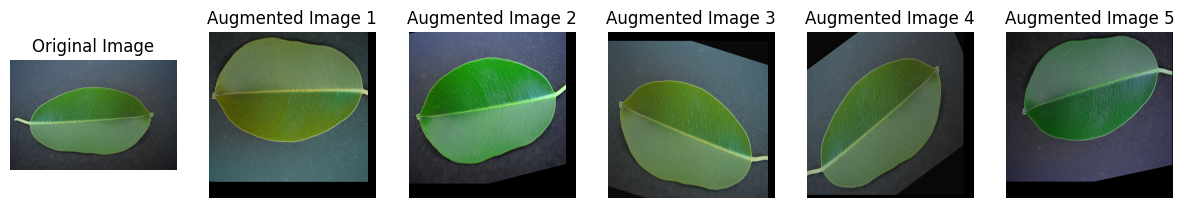

In [ ]:
# Path to the main folder
folder_path = '/content/drive/MyDrive/ColabNotebooks/Plants_2'

# Function to get all images from subfolders
def get_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Image augmentations
def augment_image(image):
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2,
                                contrast=0.2,
                                saturation=0.2,
                                hue=0.1),
        transforms.RandomResizedCrop(4000, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ])
    return augmentations(image)

# Function to visualize the original and augmented image
def visualize_augmentation(image_path):
    original_image = Image.open(image_path).convert("RGB")
    augmented_images = [augment_image(original_image) for _ in range(5)]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    for i, augmented_image in enumerate(augmented_images, start=2):
        plt.subplot(1, 6, i)
        plt.title(f'Augmented Image {i-1}')
        plt.imshow(augmented_image)
        plt.axis('off')

    plt.show()

# Getting all images
image_paths = get_image_paths(folder_path)

# Visualization of augmentations for the first image
if image_paths:
    visualize_augmentation(image_paths[0])
else:
    print("No images found.")


### **4-6. Building sequential models**


Build three simple sequential models. Choose and set the training parameters. Make one significantly larger than the others. For at least one model, do not use regularization or Batch Normalization.

#### **Data preparation**

In [ ]:
# Path to the folder
folder_path = '/content/drive/MyDrive/ColabNotebooks/Plants_2'

# Data preparation
train_dataset = image_dataset_from_directory(
    directory=folder_path + '/train',
    image_size=(128, 192),
    batch_size=32,
    label_mode='categorical'
)

valid_dataset = image_dataset_from_directory(
    directory=folder_path + '/valid',
    image_size=(128, 192),
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    directory=folder_path + '/test',
    image_size=(128, 192),
    batch_size=32,
    label_mode='categorical'
)

# Getting the number of classes from the train_dataset metadata
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Кількість класів: {num_classes}")


Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Кількість класів: 22


#### **First model**

In [ ]:
model_1 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

# Model training
history_1 = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 190, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 95, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 93, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 39424)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,046,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,142,486 (19.62 MB)

 Trainable params: 5,142,486 (19.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 801s 6s/step - accuracy: 0.2208 - loss: 16.7655 - val_accuracy: 0.4636 - val_loss: 3.7465
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 733s 5s/step - accuracy: 0.5884 - loss: 3.2853 - val_accuracy: 0.5818 - val_loss: 3.1590
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - accuracy: 0.7486 - loss: 2.4295 - val_accuracy: 0.5455 - val_loss: 3.3258
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 734s 5s/step - accuracy: 0.8068 - loss: 1.9825 - val_accuracy: 0.6545 - val_loss: 2.4268
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 746s 5s/step - accuracy: 0.8651 - loss: 1.6908 - val_accuracy: 0.6727 - val_loss: 2.4948
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 740s 5s/step - accuracy: 0.9009 - loss: 1.4235 - val_accuracy: 0.6909 - val_loss: 2.6268
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 730s 5s/step - accuracy: 0.8858 - loss: 1.3711 - val_accuracy: 0.6818 - val_loss: 2.4813
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 735s 5s/step - accuracy: 0.9236 - loss: 1.1653 - val_acc

It can be assumed that the model shows signs of overfitting. This is evident from the significant difference between training and validation losses, as well as the difference in accuracy. The model becomes too tuned to the training data but does not perform as well on the validation data.

In [ ]:
import tensorflow as tf

# Get gradients for the test data after training the model
def get_gradients(model, inputs, targets):
    with tf.GradientTape() as tape:
        # Set training=True so that the model operates as it does during training
        predictions = model(inputs, training=True)
        # Use the loss function that was applied during training
        loss_value = tf.keras.losses.categorical_crossentropy(targets, predictions)

    # Compute gradients for the weights
    gradients = tape.gradient(loss_value, model.trainable_weights)
    return gradients

# Example of obtaining gradients for the test set
for images, labels in test_dataset.take(1):
    gradients = get_gradients(model_1, images, labels)

    for i, grad in enumerate(gradients):
        print(f"Градієнт для шару {i}: {tf.reduce_mean(grad).numpy()}")


#### **Second model**

In [ ]:
model_2 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

history_2 = model_2.fit(train_dataset, validation_data=valid_dataset, epochs=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 190, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 95, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 93, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,826,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,832,822 (10.81 MB)

 Trainable params: 2,832,822 (10.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 692s 5s/step - accuracy: 0.1902 - loss: 46.0848 - val_accuracy: 0.3364 - val_loss: 2.6365
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 667s 5s/step - accuracy: 0.6536 - loss: 1.2094 - val_accuracy: 0.4909 - val_loss: 1.9658
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - accuracy: 0.8931 - loss: 0.3981 - val_accuracy: 0.5182 - val_loss: 2.6161
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 633s 5s/step - accuracy: 0.9564 - loss: 0.1629 - val_accuracy: 0.5727 - val_loss: 3.0066
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 611s 5s/step - accuracy: 0.9793 - loss: 0.0834 - val_accuracy: 0.5091 - val_loss: 3.1776
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 622s 5s/step - accuracy: 0.9752 - loss: 0.0898 - val_accuracy: 0.4273 - val_loss: 3.2734
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 613s 4s/step - accuracy: 0.9619 - loss: 0.1360 - val_accuracy: 0.4091 - val_loss: 4.2430
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 646s 5s/step - accuracy: 0.9398 - loss: 0.2088 - val_acc

It can be concluded that the model is overfitting after a few training epochs.

In [ ]:


# Get gradients for the test data after model training
def get_gradients(model, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss_value = tf.keras.losses.categorical_crossentropy(targets, predictions)


    gradients = tape.gradient(loss_value, model.trainable_weights)
    return gradients


for images, labels in test_dataset.take(1):
    gradients = get_gradients(model_2, images, labels)


    for i, grad in enumerate(gradients):
        print(f"Градієнт для шару {i}: {tf.reduce_mean(grad).numpy()}")

Градієнт для шару 0: 1.089665174484253
Градієнт для шару 1: -0.07467007637023926
Градієнт для шару 2: 4.07627010345459
Градієнт для шару 3: 0.37758195400238037
Градієнт для шару 4: 0.003611828899011016
Градієнт для шару 5: 0.05211678892374039
Градієнт для шару 6: -1.4088369937326206e-07
Градієнт для шару 7: -3.2511625391862253e-08


#### **Third model**

In [ ]:
from tensorflow.keras import layers, models, regularizers
model_3 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

history_3 = model_3.fit(train_dataset, validation_data=valid_dataset, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 190, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 95, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 93, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 20, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 10, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      15,729,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 22)                  │          11,286 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,291,414 (65.96 MB)

 Trainable params: 17,291,414 (65.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1304s 10s/step - accuracy: 0.2189 - loss: 10.2489 - val_accuracy: 0.3364 - val_loss: 1.8758
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1294s 10s/step - accuracy: 0.5491 - loss: 1.3900 - val_accuracy: 0.4273 - val_loss: 1.8640
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1350s 10s/step - accuracy: 0.6665 - loss: 1.0784 - val_accuracy: 0.5182 - val_loss: 1.4332
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1339s 10s/step - accuracy: 0.7950 - loss: 0.6167 - val_accuracy: 0.7273 - val_loss: 1.4347
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1339s 10s/step - accuracy: 0.8772 - loss: 0.3752 - val_accuracy: 0.6455 - val_loss: 1.7677
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1336s 10s/step - accuracy: 0.9017 - loss: 0.3121 - val_accuracy: 0.5545 - val_loss: 2.6595
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1349s 10s/step - accuracy: 0.8859 - loss: 0.3387 - val_accuracy: 0.6000 - val_loss: 2.1766
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1345s 10s/step - accuracy: 0.9298 - loss: 

Третя модель перенавчається після 4-5 епох

In [ ]:
import tensorflow as tf

# Get gradients for the test data after training the model
def get_gradients(model, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss_value = tf.keras.losses.categorical_crossentropy(targets, predictions)

    gradients = tape.gradient(loss_value, model.trainable_weights)
    return gradients

for images, labels in test_dataset.take(1):
    gradients = get_gradients(model_3, images, labels)

    for i, grad in enumerate(gradients):
        print(f"Градієнт для шару {i}: {tf.reduce_mean(grad).numpy()}")

Градієнт для шару 0: 12.88025951385498
Градієнт для шару 1: 0.21052449941635132
Градієнт для шару 2: 0.058460064232349396
Градієнт для шару 3: 0.03058268502354622
Градієнт для шару 4: 0.009161798283457756
Градієнт для шару 5: 0.007277396507561207
Градієнт для шару 6: 0.0017251420067623258
Градієнт для шару 7: 0.002182894852012396
Градієнт для шару 8: 0.0003523110062815249
Градієнт для шару 9: 0.014224180951714516
Градієнт для шару 10: 0.0
Градієнт для шару 11: -2.709302115988521e-09


#### **Model improvements**

##### **With both types of regularization**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(128, 192), batch_size=32, class_mode='categorical')

model_1 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),  # Dropout після MaxPooling

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),  # Dropout після MaxPooling

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Dropout перед щільним шаром
    layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

# Навчання моделі
history_1 = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=10)


#####  **Only with Dropout without L2 regularization**

In [ ]:
model_1 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 190, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 95, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 93, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 39424)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,046,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,142,486 (19.62 MB)

 Trainable params: 5,142,486 (19.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 798s 6s/step - accuracy: 0.0667 - loss: 14.3285 - val_accuracy: 0.0909 - val_loss: 3.0726
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 781s 6s/step - accuracy: 0.0808 - loss: 3.0599 - val_accuracy: 0.1000 - val_loss: 3.0048
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 806s 6s/step - accuracy: 0.0972 - loss: 2.9868 - val_accuracy: 0.1545 - val_loss: 2.8926
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 780s 6s/step - accuracy: 0.1387 - loss: 2.8651 - val_accuracy: 0.1182 - val_loss: 2.7836
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - accuracy: 0.1518 - loss: 2.7796 - val_accuracy: 0.1455 - val_loss: 2.7396
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 823s 6s/step - accuracy: 0.1578 - loss: 2.7373 - val_accuracy: 0.1909 - val_loss: 2.5688
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 785s 6s/step - accuracy: 0.2009 - loss: 2.6624 - val_accuracy: 0.1636 - val_loss: 2.4444
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 786s 6s/step - accuracy: 0.2264 - loss: 2.5295 - val_acc

#####   **Augmentation and L2 regularization**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Plants_2/train',
    target_size=(128, 192),
    batch_size=32,
    class_mode='categorical'
)

valid_dataset = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Plants_2/valid',
    target_size=(128, 192),
    batch_size=32,
    class_mode='categorical'
)

model_1 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(22, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=10)


#### **Final versions of the models**

##### **Model 1**

In [ ]:
model_1 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 190, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 190, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 95, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 93, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 93, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 39424)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,046,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,143,894 (19.62 MB)

 Trainable params: 5,143,190 (19.62 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1212s 9s/step - accuracy: 0.5648 - loss: 5.3834 - val_accuracy: 0.3545 - val_loss: 3.7796
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 905s 7s/step - accuracy: 0.8348 - loss: 2.0344 - val_accuracy: 0.5364 - val_loss: 2.8234
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 905s 7s/step - accuracy: 0.8274 - loss: 1.6010 - val_accuracy: 0.6545 - val_loss: 2.3453
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.8283 - loss: 1.7187 - val_accuracy: 0.3727 - val_loss: 3.0419
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 840s 6s/step - accuracy: 0.8476 - loss: 1.3943 - val_accuracy: 0.6091 - val_loss: 2.4422
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 896s 6s/step - accuracy: 0.8707 - loss: 1.2940 - val_accuracy: 0.1000 - val_loss: 11.0205
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 984s 7s/step - accuracy: 0.8711 - loss: 1.4548 - val_accuracy: 0.3636 - val_loss: 3.5493
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1012s 7s/step - accuracy: 0.8679 - loss: 1.3771 - val_a

##### **Model 2**

In [ ]:
model_2 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),

    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

history_2 = model_2.fit(train_dataset, validation_data=valid_dataset, epochs=10)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 190, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 126, 190, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 95, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 93, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 61, 93, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,826,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,833,270 (10.81 MB)

 Trainable params: 2,833,046 (10.81 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 713s 5s/step - accuracy: 0.5518 - loss: 3.2968 - val_accuracy: 0.5455 - val_loss: 2.5083
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step - accuracy: 0.8499 - loss: 1.5283 - val_accuracy: 0.6091 - val_loss: 1.9370
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 698s 5s/step - accuracy: 0.8895 - loss: 1.2530 - val_accuracy: 0.6455 - val_loss: 1.9413
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 704s 5s/step - accuracy: 0.8893 - loss: 1.2408 - val_accuracy: 0.5000 - val_loss: 2.5773
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 739s 5s/step - accuracy: 0.9060 - loss: 1.1797 - val_accuracy: 0.6000 - val_loss: 2.1484
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 735s 5s/step - accuracy: 0.9097 - loss: 1.2171 - val_accuracy: 0.4364 - val_loss: 2.7637
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 690s 5s/step - accuracy: 0.9023 - loss: 1.3084 - val_accuracy: 0.6909 - val_loss: 2.0030
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.9040 - loss: 1.2759 - val_accu

##### **Model 3**

In [ ]:
from tensorflow.keras import layers, models, regularizers


model_3 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dense(num_classes, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

history_3 = model_3.fit(train_dataset, validation_data=valid_dataset, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 190, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 126, 190, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 95, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 93, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 61, 93, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 20, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 20, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 10, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      15,729,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 22)                  │          11,286 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,297,302 (65.98 MB)

 Trainable params: 17,294,358 (65.97 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1899s 14s/step - accuracy: 0.5763 - loss: 14.9870 - val_accuracy: 0.2091 - val_loss: 8.5582
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1609s 12s/step - accuracy: 0.7543 - loss: 4.2758 - val_accuracy: 0.3545 - val_loss: 5.2567
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1572s 12s/step - accuracy: 0.7535 - loss: 3.2482 - val_accuracy: 0.1455 - val_loss: 6.9690
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1592s 12s/step - accuracy: 0.7439 - loss: 2.9990 - val_accuracy: 0.4182 - val_loss: 3.8152
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1558s 12s/step - accuracy: 0.7628 - loss: 2.6243 - val_accuracy: 0.3091 - val_loss: 5.4782
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1553s 11s/step - accuracy: 0.7711 - loss: 2.5179 - val_accuracy: 0.3364 - val_loss: 4.5765
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1576s 12s/step - accuracy: 0.7750 - loss: 2.5210 - val_accuracy: 0.2455 - val_loss: 5.3661
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1562s 12s/step - accuracy: 0.7734 - loss: 

### **7. Results of the already trained model**


In [ ]:
# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 192, 3))

base_model.trainable = False

modelResNet = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

modelResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Plants_2/train',
    target_size=(128, 192),
    batch_size=32,
    class_mode='categorical'
)

valid_dataset = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Plants_2/valid',
    target_size=(128, 192),
    batch_size=32,
    class_mode='categorical'
)

historyResNet = modelResNet.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10
)

Found 4275 images belonging to 22 classes.
Found 110 images belonging to 22 classes.
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1137s 8s/step - accuracy: 0.0796 - loss: 3.5807 - val_accuracy: 0.1000 - val_loss: 3.1209
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1118s 8s/step - accuracy: 0.1136 - loss: 2.9314 - val_accuracy: 0.0727 - val_loss: 2.9932
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1043s 8s/step - accuracy: 0.1652 - loss: 2.7667 - val_accuracy: 0.1818 - val_loss: 2.8831
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1038s 7s/step - accuracy: 0.2070 - loss: 2.6440 - val_accuracy: 0.1818 - val_loss: 2.7632
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1036s 7s/step - accuracy: 0.2399 - loss: 2.5146 - val_accuracy: 0.2455 - val_loss: 2.6263
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1047s 7s/step - accuracy: 0.2522 - loss: 2.4086 - val_accuracy: 0.2455 - val_loss: 2.5700
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1048s 8s/step - accuracy: 0.3087 - loss: 2.2690 - val_accuracy: 0.2364 - val_loss: 2.4069
Epoch

### **8. Transfer learning**


In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Кількість класів: {num_classes}")

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 192, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Plants_2/train',
    target_size=(128, 192),
    batch_size=32,
    class_mode='categorical'
)

valid_dataset = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Plants_2/valid',
    target_size=(128, 192),
    batch_size=32,
    class_mode='categorical'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=10,
                    callbacks=[reduce_lr])



Кількість класів: 22
Found 4275 images belonging to 22 classes.
Found 110 images belonging to 22 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 3685s 26s/step - accuracy: 0.1746 - loss: 2.8066 - val_accuracy: 0.0455 - val_loss: 8.4573 - learning_rate: 1.0000e-04
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1276s 9s/step - accuracy: 0.4004 - loss: 1.9192 - val_accuracy: 0.0455 - val_loss: 18.1479 - learning_rate: 1.0000e-04
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1279s 9s/step - accuracy: 0.5003 - loss: 1.5864 - val_accuracy: 0.0545 - val_loss: 10.4949 - learning_rate: 1.0000e-04
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1278s 9s/step - accuracy: 0.5496 - loss: 1.4328 - val_accuracy: 0.1091 - val_loss: 4.9807 - learning_rate: 1.0000e-04
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1272s 9s/step - accuracy: 0.5867 - loss: 1.2626 - val_accuracy: 0.2182 - val_loss: 3.3458 - learning_rate: 1.0000e-04
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1297s 9s/step - accuracy: 0.6150 - loss: 1.1687 - val_accuracy: 0.3545 - val_loss: 1.7405 - learning_rate: 1.0000e-04
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1239s 9s/step - accu

### **9. Class Activation Maps and Saliency Maps**


In [ ]:
# Model Definition
num_classes = 22
model_1 = models.Sequential([
    layers.InputLayer(input_shape=(128, 192, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Dummy training (replace with real dataset)
model_1.fit(train_dataset, validation_data=valid_dataset, epochs=5)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 949s 7s/step - accuracy: 0.6100 - loss: 5.1380 - val_accuracy: 0.2273 - val_loss: 3.8576
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 924s 7s/step - accuracy: 0.8353 - loss: 2.0701 - val_accuracy: 0.4364 - val_loss: 2.9769
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1008s 7s/step - accuracy: 0.8294 - loss: 1.6111 - val_accuracy: 0.1000 - val_loss: 4.6759
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 963s 7s/step - accuracy: 0.8519 - loss: 1.5064 - val_accuracy: 0.3818 - val_loss: 2.9026
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 917s 7s/step - accuracy: 0.8490 - loss: 1.4368 - val_accuracy: 0.1364 - val_loss: 5.9617


In [ ]:
def get_cam(model, img_array, class_index):

    # Run a forward pass to initialize layer outputs
    _ = model(img_array)

    # Identify the last Conv2D layer
    last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)][-1]
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Build a model for CAM
    heatmap_model = tf.keras.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0] * pooled_grads
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize heatmap
    return heatmap

def display_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Function to generate Saliency Map
def get_saliency_map(model, img_array, class_index):
    img_array = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, img_array)
    saliency = np.max(np.abs(grads), axis=-1)[0]
    return saliency

def display_saliency_map(img_path, saliency):
    img = cv2.imread(img_path)
    saliency = cv2.resize(saliency, (img.shape[1], img.shape[0]))
    plt.figure(figsize=(10, 10))
    plt.imshow(img, alpha=0.6)
    plt.imshow(saliency, cmap='hot', alpha=0.4)
    plt.axis('off')
    plt.show()

# Example usage
img_path = folder_path + '/test/Arjun healthy (P1b)/0002_0006.JPG'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 192))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Predict and visualize CAM and Saliency
predictions = model_1.predict(img_array)
class_index = np.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [ ]:
heatmap = get_cam(model_1, img_array, class_index)
display_cam(img_path, heatmap)

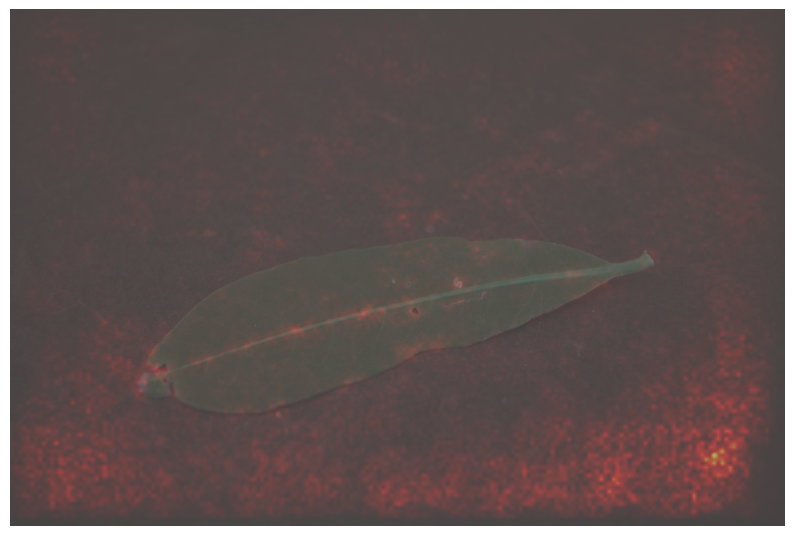

In [ ]:
# Display Saliency Map
saliency_map = get_saliency_map(model_1, img_array, class_index)
display_saliency_map(img_path, saliency_map)

####  **10. Teacher-Student models**

Epoch [1/10], Teacher Loss: 0.3114
Epoch [2/10], Teacher Loss: 0.1019
Epoch [3/10], Teacher Loss: 0.0832
Epoch [4/10], Teacher Loss: 0.0291
Epoch [5/10], Teacher Loss: 0.1082
Epoch [6/10], Teacher Loss: 0.0431
Epoch [7/10], Teacher Loss: 0.0054
Epoch [8/10], Teacher Loss: 0.0008
Epoch [9/10], Teacher Loss: 0.0019
Epoch [10/10], Teacher Loss: 0.0090
Epoch [1/10], Student Average Loss: 0.1786
Epoch [2/10], Student Average Loss: 0.1473
Epoch [3/10], Student Average Loss: 0.1301
Epoch [4/10], Student Average Loss: 0.0191
Epoch [5/10], Student Average Loss: 0.0680
Epoch [6/10], Student Average Loss: 0.2484
Epoch [7/10], Student Average Loss: 0.1704
Epoch [8/10], Student Average Loss: 0.0206
Epoch [9/10], Student Average Loss: 0.0123
Epoch [10/10], Student Average Loss: 0.0062


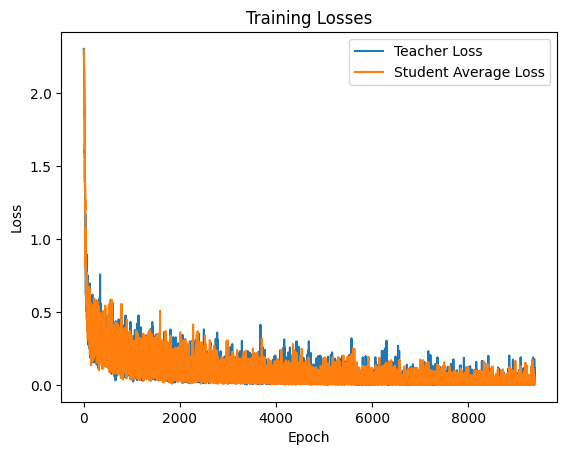

Навчання завершено.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

num_epochs = 10
batch_size = 64
learning_rate = 0.001

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

teacher_model = TeacherModel()
student_model = StudentModel()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

teacher_losses = []
student_losses = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        teacher_optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        teacher_optimizer.step()

        teacher_losses.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Teacher Loss: {loss.item():.4f}')

for epoch in range(num_epochs):
    for images, labels in train_loader:
        with torch.no_grad():
            teacher_outputs = teacher_model(images)
            pseudo_labels = torch.argmax(teacher_outputs, dim=1)

        student_optimizer.zero_grad()
        student_outputs = student_model(images)
        average_loss = criterion(student_outputs, pseudo_labels)
        average_loss.backward()
        student_optimizer.step()

        student_losses.append(average_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Student Average Loss: {average_loss.item():.4f}')

plt.plot(range(1, len(teacher_losses) + 1), teacher_losses, label='Teacher Loss')
plt.plot(range(1, len(student_losses) + 1), student_losses, label='Student Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

print('Навчання завершено.')


#### Results Analysis

##### 1. Teacher Loss:

* The teacher loss starts at 0.3114 in the first epoch, indicating that the model was initially not very accurate.
* Subsequently, the loss decreases significantly, reaching 0.0008 by the eighth epoch. This indicates that the teacher model improved and became more accurate in its predictions.
* After the eighth epoch, the loss slightly increases in the ninth epoch (0.0019) but remains very low, indicating model stability.

##### 2. Student Average Loss:

* The student loss also decreases, starting from 0.1786 and reaching 0.0062 by the tenth epoch.
* Some instability is observed, with a peak at the sixth epoch (0.2484), which may be related to training issues or insufficient information from the teacher.
* Overall, the student loss decreases, showing that the student model learns over time and adapts to the knowledge transferred from the teacher.

##### Conclusions

* Teacher effectiveness: The teacher achieved a significant reduction in loss, indicating high accuracy and efficiency in training.
* Student adaptation: Although the student initially had higher loss, it showed gradual improvement during training, demonstrating the effectiveness of learning from the teacher's knowledge.
* Potential issues: The peak in student loss at the sixth epoch may indicate difficulty in adapting to the teacher-provided information, possibly due to insufficient epochs or limited data diversity.
